In [1]:
import matplotlib.pyplot as plt
import stistools
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from stsci.tools import teal
from astropy.time import Time
import sys
import os
import time
import re
import json
from os import listdir
from os.path import isfile, join
import warnings 

import requests
from urllib.parse import quote as urlencode

from astropy.table import Table
import numpy as np

import pprint
pp = pprint.PrettyPrinter(indent=4)


def mast_query(request):
    """Perform a MAST query.
    
        Parameters
        ----------
        request (dictionary): The MAST request json object
        
        Returns head,content where head is the response HTTP headers, and content is the returned data"""
    
    # Base API url
    request_url='https://mast.stsci.edu/api/v0/invoke'    
    
    # Grab Python Version 
    version = ".".join(map(str, sys.version_info[:3]))

    # Create Http Header Variables
    headers = {"Content-type": "application/x-www-form-urlencoded",
               "Accept": "text/plain",
               "User-agent":"python-requests/"+version}

    # Encoding the request as a json string
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    # Perform the HTTP request
    resp = requests.post(request_url, data="request="+req_string, headers=headers)
    
    # Pull out the headers and response content
    head = resp.headers
    content = resp.content.decode('utf-8')

    return head, content

/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


In [5]:
def phase(t, t0, z):
    return (t-t0)/(1+z)

def get_mast_list(ra, dec, z, t0, t_l = -30, t_u = 5000):
    # read the list of spectral data on MAST for a certain object
    mast_request = {'service':'Mast.Caom.Cone',
                    'params':{'ra':ra,
                              'dec':dec,
                              'radius':0.2,
                             'mission':'HST',
                             'product_type':'spectrum'},
                    'format':'json',
                    'pagesize':2000,
                    'page':1,
                    'removenullcolumns':True,
                    'removecache':True}

    headers, mast_data_str = mast_query(mast_request)

    mast_data = json.loads(mast_data_str)

#    print(mast_data.keys())
    print("Query status:",mast_data['status'])
    
    
    ind = np.zeros(len(mast_data['data']),dtype=bool)
    i = 0
    for item in mast_data['data']:
        if item['dataproduct_type']=='spectrum' and item['t_min'] is not None and phase(item['t_min'], t0, z)<t_u and phase(item['t_min'], t0, z)>t_l:
            ind[i] = True
            print(item['target_name'], item['instrument_name'], item['filters'], 
                  item['t_min'],phase(item['t_min'], t0, z), item['obs_id'], )
        i +=1
    return np.array(mast_data['data'])[ind]

# start reading list from MAST

could write it in a more organized way...

In [6]:
z_nxt = 0.023
t0_nxt = 59031.1
nxt_list = get_mast_list(339.4009805,35.0021328, z_nxt, t0_nxt)

Query status: COMPLETE
AT2020NXT STIS/NUV-MAMA G230L 59049.64291571 18.126017311828615 oe4w01010
AT2020NXT STIS/FUV-MAMA G140L 59049.70910791 18.190721319648684 oe4w02010
AT2020NXT STIS/FUV-MAMA G140L 59049.77529977 18.255424995114677 oe4w03010
AT2020NXT STIS/NUV-MAMA G230L 59058.6492005 26.929814760506183 oe4w04010
AT2020NXT STIS/NUV-MAMA G230L 59058.71533457 26.99446194525945 oe4w05010
AT2020NXT STIS/NUV-MAMA G230L 59058.78145718 27.059097927662453 oe4w06010


In [7]:
z_fqv = 0.007522
t0_fqv = 58938.9
fqv_list = get_mast_list(189.1385821,11.2316530	, z_fqv, t0_fqv)

Query status: COMPLETE
TESS-SN COS/FUV G160M 58943.95643885417 5.018688280918864 le2ba4d9q
TESS-SN COS/FUV G160M 58943.958905520834 5.021136531840419 le2ba4daq
TESS-SN COS/FUV G160M 58950.77377033565 11.785122643123952 le2ba5k6q
TESS-SN COS/FUV G160M 58950.776085150464 11.787420175899921 le2ba5k7q
TESS-SN STIS/NUV-MAMA G230L 58950.71223024306 11.724041999139024 oe2b05010
TESS-SN STIS/CCD G430L 58950.725887650464 11.737597442499906 oe2b05020
TESS-SN STIS/NUV-MAMA G230L 58956.60397804398 17.571802942249295 oe2b25010
TESS-SN STIS/NUV-MAMA G230L 58956.66449876157 17.631871821728264 oe2b25020
TESS-SN STIS/NUV-MAMA G230L 58956.730691006946 17.69756988625966 oe2b25030
TESS-SN STIS/NUV-MAMA G230L 58956.79689467593 17.76327928911417 oe2b25040
TESS-SN STIS/CCD G430L 58956.80635061343 17.772664630078733 oe2b25050
TESS-SN STIS/CCD G230LB 58944.488930555555 5.547204483429459 oe2b03010
TESS-SN STIS/CCD G230LB 58944.55512276621 5.6129025134992085 oe2ba3010
TESS-SN STIS/CCD G230LB 58944.62132646991 5.

In [8]:
z_10jl = 0.0107
t0_10jl = 55488.
sn2010jl_list = get_mast_list(145.72221,9.49494, z_10jl, t0_10jl)

Query status: COMPLETE
SN2010JL COS/FUV G130M 55522.18796466435 33.82602618417943 lbk003010
SN2010JL COS/FUV G160M 55522.20217762732 33.84008867845822 lbk003020
SN2010JL COS/FUV G130M 55584.828904050926 95.80380335502743 lbk005010
SN2010JL COS/FUV G160M 55584.88870737269 95.86297355564199 lbk005020
SN2010JL COS/FUV G130M 56098.18289783565 603.7230610820717 lboo22010
SN2010JL COS/FUV G130M 56098.23509710648 603.7747077337298 lboo22020
SN2010JL COS/FUV G130M 56098.25273599537 603.7921598846023 lboo22030
SN2010JL COS/FUV G130M 56098.302180439816 603.8410808744592 lboo22040
SN2010JL COS/FUV G160M 56098.848013773146 604.3811356219906 lboo23010
SN2010JL COS/FUV G160M 56098.90001600694 604.4325873225891 lboo23020
SN2010JL COS/FUV G160M 56098.917654895835 604.4500394734688 lboo23030
SN2010JL COS/FUV G160M 56098.96650894676 604.4983763201344 lboo23040
SN-2010JL STIS/FUV-MAMA G140L 56727.5441909375 1226.4214810898393 ocdd03010
SN-2010JL STIS/FUV-MAMA G140L 56727.55176056713 1226.4289705819003 oc

In [9]:
z_05ip = 0.0072
t0_05ip = 53679.66
sn2005ip_list = get_mast_list(143.02675,8.44567, z_05ip, t0_05ip)
#2005ip has spectra as late as ~few hundreds days

Query status: COMPLETE
SN-2005IP STIS/FUV-MAMA G140L 56744.4039133912 3042.835497806987 ocdd02010
SN-2005IP STIS/FUV-MAMA G140L 56744.41165671296 3042.843185775374 ocdd02020
SN-2005IP STIS/FUV-MAMA G140L 56744.41832337963 3042.8498047851713 ocdd02030
SN-2005IP STIS/FUV-MAMA G140L 56744.4249900463 3042.856423794969 ocdd02040
SN-2005IP STIS/FUV-MAMA G140L 56744.46132079861 3042.89249483579 ocdd02050
SN-2005IP STIS/FUV-MAMA G140L 56744.47179560185 3042.9028947595775 ocdd02060
SN-2005IP STIS/FUV-MAMA G140L 56744.4799900463 3042.911030625787 ocdd02070
SN-2005IP STIS/FUV-MAMA G140L 56744.48818449074 3042.919166491997 ocdd02080
SN-2005IP STIS/NUV-MAMA G230L 56744.52773302 3042.95843230738 ocdd02090
SN-2005IP STIS/NUV-MAMA G230L 56744.53730486 3042.9679357227933 ocdd020a0
SN-2005IP STIS/NUV-MAMA G230L 56744.54580003 3042.976370164808 ocdd020b0
SN-2005IP STIS/NUV-MAMA G230L 56744.5542956 3042.984805003967 ocdd020c0
SN-2005IP STIS/FUV-MAMA G140L 58047.774841087965 4336.889238570255 od8701010
SN-

In [10]:
z_11fe = 0.0008
t0_11fe = 55796.696
sn2011fe_list = get_mast_list(210.77421,54.27372, z_11fe, t0_11fe)


Query status: COMPLETE
SN2011FE STIS/NUV-MAMA G230L 56190.96343461 393.9522727917623 obyc01010
SN2011FE STIS/NUV-MAMA G230L 56191.08358538 394.07232751798387 obyc01020
SN2011FE STIS/NUV-MAMA G230L 56191.21654834 394.20518419264454 obyc01030
SN2011FE STIS/NUV-MAMA G230L 56191.82720795 394.81535566546614 obyc02010
SN2011FE STIS/NUV-MAMA G230L 56191.9478098 394.9358611111112 obyc02020
SN2011FE STIS/CCD G430L 56192.08930278 395.0772409872042 obyc03010
SN2011FE STIS/CCD G750L 56192.10750872 395.0954323740978 obyc03020
CCDFLAT STIS/CCD G750L 56192.11731204 395.10522785770837 obyc03030
PTF11KLY STIS/CCD G750L 55801.11054051 4.411011700638404 obnd43020
PTF11KLY STIS/NUV-MAMA G230L 55801.16724236 4.467668225419116 obnd48010
PTF11KLY STIS/CCD G750L 55804.24709163 7.545055585528822 obnd44040
PTF11KLY STIS/CCD G750L 55804.24102682 7.538995623494133 obnd44030
PTF11KLY STIS/NUV-MAMA G230L 55804.29012422 7.588053776977194 obnd49010
PTF11KLY STIS/CCD G750L 55807.44253125 10.737940897281128 obnd45030
P

In [11]:
z_18agk = 0.026128
t0_18agk = 58185.22
sn2018agk_list = get_mast_list(197.651625,-4.4857417, z_18agk, t0_18agk)


Query status: COMPLETE
SNAT2018AGK STIS/NUV-MAMA G230L 58196.71490355 11.202212150916647 odm350010
SNAT2018AGK STIS/NUV-MAMA G230L 58196.77189429 11.257751752219662 odm350020
SNAT2018AGK STIS/NUV-MAMA G230L 58196.83812133 11.322292472284722 odm350030
SNAT2018AGK STIS/CCD G430L 58196.9042439 11.386731382435366 odm350040
SNAT2018AGK STIS/CCD G430L 58196.91482242 11.397040544651652 odm350050
SNAT2018AGK STIS/CCD G750L 58196.9274728 11.40936881168888 odm350060
CCDFLAT STIS/CCD G750L 58196.93592207 11.417602940371728 odm350070
SNAT2018AGK STIS/NUV-MAMA G230L 58201.68058649 16.041455344752727 odm351010
SNAT2018AGK STIS/NUV-MAMA G230L 58201.7384917 16.097886131165502 odm351020
SNAT2018AGK STIS/NUV-MAMA G230L 58201.80471837 16.162426490647604 odm351030
SNAT2018AGK STIS/CCD G430L 58201.87085243 16.22687659824181 odm351040
SNAT2018AGK STIS/CCD G430L 58201.88143133 16.237186130776575 odm351050
SNAT2018AGK STIS/CCD G750L 58201.89408168 16.249514368578883 odm351060
CCDFLAT STIS/CCD G750L 58201.9025

In [12]:
z_11by = 0.003402
t0_11by = 55672.4
sn2011by_list = get_mast_list(178.93983,55.32606, z_11by, t0_11by)


Query status: COMPLETE


In [13]:
z_21csp = 0.083
t0_21csp = 59255.47
sn2021csp_list = get_mast_list(216.5921432,5.859215587, z_21csp, t0_21csp)


Query status: COMPLETE
ZTF21AAKILYD STIS/NUV-MAMA G230L 59263.5067534375 7.420824965370612 oedo02010
ZTF21AAKILYD STIS/NUV-MAMA G230L 59267.082274155095 10.72232147284716 oedo04010
ZTF21AAKILYD COS/FUV G140L 59263.83714876157 7.725899133492175 ledo01010
ZTF21AAKILYD COS/FUV G140L 59269.665482094904 13.107555027611383 ledo03010


In [14]:
z_98S = 0.003
t0_98S = 50875.2
sn1998S_list = get_mast_list(176.52575,47.48208, z_98S, t0_98S)


Query status: COMPLETE
SN1998S STIS/CCD G430L 51112.41242955 236.50292078764053 o48z60010
SN1998S STIS/FUV-MAMA G140L 51112.42524216 236.5156950747817 o48z60020
SN1998S STIS/FUV-MAMA G140L 51112.47284661 236.56315713858584 o48z60030
SN1998S STIS/FUV-MAMA G140L 51112.54002253 236.63013213360574 o48z60040
SN1998S STIS/NUV-MAMA G230L 51112.60980255 236.69970343968708 o48z60050
SN1998S STIS/NUV-MAMA G230L 51112.67435104 236.76405886341013 o48z60060
SN1998S STIS/CCD G430L 50888.07592307 12.837410837489125 o48z50010
SN1998S STIS/FUV-MAMA G140L 50888.08283267 12.844299770690176 o48z50020
SN1998S STIS/FUV-MAMA G140L 50888.13600417 12.897312233305701 o48z50030
SN1998S STIS/NUV-MAMA G230L 50888.20585378 12.966952921235892 o48z50040
SN1998S STIS/CCD G430L 50902.65660556 27.374482113659777 o48z55010
SN1998S STIS/FUV-MAMA G140L 50902.66490448 27.382756211368484 o48z55020
SN1998S STIS/FUV-MAMA G140L 50902.71610818 27.433806759724188 o48z55030
SN1998S STIS/FUV-MAMA G140L 50902.78328411 27.50078176471

In [15]:
z_15G = 0.0045
t0_15G = 57104.75317
sn2015G_list = get_mast_list(309.35658,66.11986, z_15G, t0_15G)


Query status: COMPLETE
PSN2037+6607 STIS/CCD G430L 57116.81624881 12.009038138372528 ocmy01070
PSN2037+6607 STIS/CCD G750L 57116.82195475 12.014718516668928 ocmy01080
PSN2037+6607 STIS/CCD G430L 57132.45106432 27.573812165250168 ocmy03060
PSN2037+6607 STIS/CCD G750L 57132.45677025 27.579492533594188 ocmy03070
PSN2037+6607 STIS/CCD G430L 57123.64123735 18.803451816819567 ocmy02060
PSN2037+6607 STIS/CCD G750L 57123.64694329 18.809132195115968 ocmy02070
PSN2037+6607 STIS/NUV-MAMA G230L 57116.78970957 11.9826177899444 ocmy01060
PSN2037+6607 STIS/NUV-MAMA G230L 57116.66429291 11.857762976599748 ocmy01040
PSN2037+6607 STIS/NUV-MAMA G230L 57116.59090177 11.784700617222164 ocmy01030
PSN2037+6607 STIS/NUV-MAMA G230L 57116.46573993 11.660099482323606 ocmy01010
PSN2037+6607 STIS/NUV-MAMA G230L 57116.72343661 11.916641722248245 ocmy01050
PSN2037+6607 STIS/NUV-MAMA G230L 57116.52464031 11.718735998008095 ocmy01020
PSN2037+6607 STIS/NUV-MAMA G230L 57132.2943399 27.417789845690415 ocmy03030
PSN2037+6

In [16]:
z_20aekp = 0.046
t0_20aekp = 59210
sn2020aekp_list = get_mast_list(235.7974551,17.8131193, z_20aekp, t0_20aekp)


Query status: COMPLETE
ZTF21AAABWZX STIS/FUV-MAMA G140L 59471.81190170139 250.298185182972 oecz02010
ZTF21AAABWZX STIS/FUV-MAMA G140L 59471.87169355324 250.35534756524183 oecz02020
ZTF21AAABWZX STIS/FUV-MAMA G140L 59471.93836021991 250.41908242821094 oecz02030
ZTF21AAABWZX STIS/NUV-MAMA G230L 59472.01237650463 250.48984369467502 oecz02040
ZTF21AAABWZX STIS/NUV-MAMA G230L 59472.07022357639 250.54514682255186 oecz02050
ZTF21AAABWZX STIS/FUV-MAMA G140L 59421.834203935185 202.51835940266216 oeczz1010
ZTF21AAABWZX STIS/FUV-MAMA G140L 59421.899909872685 202.5811757865061 oeczz1020
ZTF21AAABWZX STIS/FUV-MAMA G140L 59421.96657653935 202.6449106494752 oeczz1030
ZTF21AAABWZX STIS/NUV-MAMA G230L 59422.03253726852 202.7079706199984 oeczz1040
ZTF21AAABWZX STIS/NUV-MAMA G230L 59422.09874097222 202.77126287975335 oeczz1050


# getting data

 just for downloading the data under current folder, if it has been done before, no need to repeat

In [3]:
def get_mast_data(item, target_name):
    obsid = item['obsid']

    product_request = {'service':'Mast.Caom.Products',
                      'params':{'obsid':obsid},
                      'format':'json',
                      'pagesize':100,
                      'page':1}   

    headers, obs_products_string = mast_query(product_request)

    obs_products = json.loads(obs_products_string)

    print("Number of data products:", len(obs_products["data"]))
    
#    pp.pprint([x.get('productType',"") for x in obs_products["data"]])
    
    sci_prod_arr = [x for x in obs_products['data'] if x.get("productType", None) == 'SCIENCE']
    science_products = Table()

    for col, atype in [(x['name'], x['type']) for x in obs_products['fields']]:
        if atype=="string":
            atype="str"
        if atype=="boolean":
            atype="bool"
        if atype == "int":
            atype = "float" # array may contain nan values, and they do not exist in numpy integer arrays
        science_products[col] = np.array([x.get(col,None) for x in sci_prod_arr],dtype=atype)

    print("Number of science products:",len(science_products))
    print(science_products)

    download_url = 'https://mast.stsci.edu/api/v0.1/Download/file?'

    for row in science_products:     
        # make file path
        out_path = os.path.join('./',target_name, row['obs_collection'], row['obs_id'])
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        out_path = os.path.join(out_path, os.path.basename(row['productFilename']))

        # Download the data
        payload = {"uri":row['dataURI']}
        resp = requests.get(download_url, params=payload)

        # save to file
        with open(out_path,'wb') as FLE:
            FLE.write(resp.content)

        # check for file 
        if not os.path.isfile(out_path):
            print("ERROR: " + out_path + " failed to download.")
        else:
            print("COMPLETE: ", out_path)
            
            
#print("Product information column names:")
#pp.pprint(obs_products['fields'])


In [43]:

for item in sn2015G_list:
    get_mast_data(item, '2015G')

for item in nxt_list:
    get_mast_data(item, '2020nxt')

for item in fqv_list:
    get_mast_data(item, '2020fqv')
    
for item in sn2010jl_list:
    get_mast_data(item, '2010jl')
    
for item in sn2005ip_list:
    get_mast_data(item, '2005ip')
    
for item in sn1998S_list:
    get_mast_data(item, '1998S')
    
for item in sn2011by_list:
    get_mast_data(item, '2011by')
    
for item in sn2011fe_list:
    get_mast_data(item, '2011fe')

for item in sn2018agk_list:
    get_mast_data(item, '2018agk')

for item in sn2021csp_list:
    get_mast_data(item, '2021csp')


Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24981430            HST         spectrum ...     PUBLIC         1.0      False
24981430            HST         spectrum ...     PUBLIC         2.0      False
24981430            HST         spectrum ...     PUBLIC         3.0      False
24981430            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2015G/HST/ocmy01070/ocmy01070_raw.fits
COMPLETE:  ./2015G/HST/ocmy01070/ocmy01070_flt.fits
COMPLETE:  ./2015G/HST/ocmy01070/ocmy01070_sx1.fits
COMPLETE:  ./2015G/HST/ocmy01070/ocmy01070_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24981431            HST         spectrum ...

COMPLETE:  ./2015G/HST/ocmy01020/ocmy01020_x2d.fits
COMPLETE:  ./2015G/HST/ocmy01020/ocmy01020_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24981443            HST         spectrum ...     PUBLIC         1.0      False
24981443            HST         spectrum ...     PUBLIC         2.0      False
24981443            HST         spectrum ...     PUBLIC         2.0      False
24981443            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2015G/HST/ocmy03030/ocmy03030_raw.fits
COMPLETE:  ./2015G/HST/ocmy03030/ocmy03030_x1d.fits
COMPLETE:  ./2015G/HST/ocmy03030/ocmy03030_x2d.fits
COMPLETE:  ./2015G/HST/ocmy03030/ocmy03030_flt.fits
Number of data products: 12
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- ----------

COMPLETE:  ./2015G/HST/ocmy03080/ocmy03080_raw.fits
COMPLETE:  ./2015G/HST/ocmy03080/ocmy03080_flt.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24981440            HST         spectrum ...     PUBLIC         1.0      False
24981440            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2015G/HST/ocmy02080/ocmy02080_raw.fits
COMPLETE:  ./2015G/HST/ocmy02080/ocmy02080_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
26281182            HST         spectrum ...     PUBLIC         1.0      False
26281182            HST         spectrum ...     PUBLIC         2.0      False
26281182            HST         spectrum ... 

COMPLETE:  ./2020fqv/HST/oe2b25010/oe2b25010_raw.fits
COMPLETE:  ./2020fqv/HST/oe2b25010/oe2b25010_x1d.fits
COMPLETE:  ./2020fqv/HST/oe2b25010/oe2b25010_x2d.fits
COMPLETE:  ./2020fqv/HST/oe2b25010/oe2b25010_flt.fits
Number of data products: 13
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
26270300            HST         spectrum ...     PUBLIC         1.0      False
26270300            HST         spectrum ...     PUBLIC         2.0      False
26270300            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2020fqv/HST/oe2b25020/oe2b25020_raw.fits
COMPLETE:  ./2020fqv/HST/oe2b25020/oe2b25020_x2d.fits
COMPLETE:  ./2020fqv/HST/oe2b25020/oe2b25020_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- --------

COMPLETE:  ./2020fqv/HST/oe2ba2010/oe2ba2010_raw.fits
COMPLETE:  ./2020fqv/HST/oe2ba2010/oe2ba2010_flt.fits
COMPLETE:  ./2020fqv/HST/oe2ba2010/oe2ba2010_sx2.fits
Number of data products: 19
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
26268802            HST         spectrum ...     PUBLIC         1.0      False
26268802            HST         spectrum ...     PUBLIC         2.0      False
26268802            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2020fqv/HST/oe2bb2010/oe2bb2010_raw.fits
COMPLETE:  ./2020fqv/HST/oe2bb2010/oe2bb2010_flt.fits
COMPLETE:  ./2020fqv/HST/oe2bb2010/oe2bb2010_sx2.fits
Number of data products: 20
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
2626880

COMPLETE:  ./2010jl/HST/lbk003020/lbk003020_x1dsum.fits
COMPLETE:  ./2010jl/HST/lbk003cfq/lbk003cfq_x1d.fits
Number of data products: 26
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24843530            HST         spectrum ...     PUBLIC         3.0      False
24142477            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/lbk005010/lbk005010_x1dsum.fits
COMPLETE:  ./2010jl/HST/lbk005lmq/lbk005lmq_x1d.fits
Number of data products: 26
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24843531            HST         spectrum ...     PUBLIC         3.0      False
24142478            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/lbk005020/

COMPLETE:  ./2010jl/HST/ocdd03050/ocdd03050_raw.fits
COMPLETE:  ./2010jl/HST/ocdd03050/ocdd03050_x1d.fits
COMPLETE:  ./2010jl/HST/ocdd03050/ocdd03050_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd03050/ocdd03050_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24970346            HST         spectrum ...     PUBLIC         1.0      False
24970346            HST         spectrum ...     PUBLIC         2.0      False
24970346            HST         spectrum ...     PUBLIC         2.0      False
24970346            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/ocdd03060/ocdd03060_raw.fits
COMPLETE:  ./2010jl/HST/ocdd03060/ocdd03060_x1d.fits
COMPLETE:  ./2010jl/HST/ocdd03060/ocdd03060_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd03060/ocdd03060_flt.fits
Number of data products: 15
Number of scienc

COMPLETE:  ./2010jl/HST/ocdd030g0/ocdd030g0_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd030g0/ocdd030g0_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24970357            HST         spectrum ...     PUBLIC         1.0      False
24970357            HST         spectrum ...     PUBLIC         2.0      False
24970357            HST         spectrum ...     PUBLIC         2.0      False
24970357            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/ocdd030h0/ocdd030h0_raw.fits
COMPLETE:  ./2010jl/HST/ocdd030h0/ocdd030h0_x1d.fits
COMPLETE:  ./2010jl/HST/ocdd030h0/ocdd030h0_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd030h0/ocdd030h0_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- ----

COMPLETE:  ./2010jl/HST/obk002010/obk002010_sx2.fits
Number of data products: 12
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24961454            HST         spectrum ...     PUBLIC         1.0      False
24961454            HST         spectrum ...     PUBLIC         2.0      False
24961454            HST         spectrum ...     PUBLIC         3.0      False
24961454            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2010jl/HST/obk004010/obk004010_raw.fits
COMPLETE:  ./2010jl/HST/obk004010/obk004010_flt.fits
COMPLETE:  ./2010jl/HST/obk004010/obk004010_sx1.fits
COMPLETE:  ./2010jl/HST/obk004010/obk004010_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------

COMPLETE:  ./2010jl/HST/oboo20020/oboo20020_raw.fits
COMPLETE:  ./2010jl/HST/oboo20020/oboo20020_x1d.fits
COMPLETE:  ./2010jl/HST/oboo20020/oboo20020_x2d.fits
COMPLETE:  ./2010jl/HST/oboo20020/oboo20020_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963376            HST         spectrum ...     PUBLIC         1.0      False
24963376            HST         spectrum ...     PUBLIC         2.0      False
24963376            HST         spectrum ...     PUBLIC         2.0      False
24963376            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/oboo20030/oboo20030_raw.fits
COMPLETE:  ./2010jl/HST/oboo20030/oboo20030_x1d.fits
COMPLETE:  ./2010jl/HST/oboo20030/oboo20030_x2d.fits
COMPLETE:  ./2010jl/HST/oboo20030/oboo20030_flt.fits
Number of data products: 15
Number of scienc

COMPLETE:  ./2010jl/HST/ocdd05040/ocdd05040_raw.fits
COMPLETE:  ./2010jl/HST/ocdd05040/ocdd05040_x1d.fits
COMPLETE:  ./2010jl/HST/ocdd05040/ocdd05040_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd05040/ocdd05040_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24981286            HST         spectrum ...     PUBLIC         1.0      False
24981286            HST         spectrum ...     PUBLIC         2.0      False
24981286            HST         spectrum ...     PUBLIC         2.0      False
24981286            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2010jl/HST/ocdd05080/ocdd05080_raw.fits
COMPLETE:  ./2010jl/HST/ocdd05080/ocdd05080_x1d.fits
COMPLETE:  ./2010jl/HST/ocdd05080/ocdd05080_x2d.fits
COMPLETE:  ./2010jl/HST/ocdd05080/ocdd05080_flt.fits
Number of data products: 15
Number of scienc

COMPLETE:  ./2010jl/HST/lcy401010/lcy401010_x1dsum.fits
COMPLETE:  ./2010jl/HST/lcy401ciq/lcy401ciq_flt.fits
COMPLETE:  ./2010jl/HST/lcy401ciq/lcy401ciq_rawtag.fits
COMPLETE:  ./2010jl/HST/lcy401ciq/lcy401ciq_x1d.fits
COMPLETE:  ./2010jl/HST/lcy401ckq/lcy401ckq_flt.fits
COMPLETE:  ./2010jl/HST/lcy401ckq/lcy401ckq_rawtag.fits
COMPLETE:  ./2010jl/HST/lcy401ckq/lcy401ckq_x1d.fits
COMPLETE:  ./2010jl/HST/lcy401cmq/lcy401cmq_flt.fits
COMPLETE:  ./2010jl/HST/lcy401cmq/lcy401cmq_rawtag.fits
COMPLETE:  ./2010jl/HST/lcy401cmq/lcy401cmq_x1d.fits
COMPLETE:  ./2010jl/HST/lcy401coq/lcy401coq_flt.fits
COMPLETE:  ./2010jl/HST/lcy401coq/lcy401coq_rawtag.fits
COMPLETE:  ./2010jl/HST/lcy401coq/lcy401coq_x1d.fits
Number of data products: 20
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24960515            HST         spectrum ...     PUBLIC         1.0      False
2

COMPLETE:  ./2005ip/HST/ocdd020a0/ocdd020a0_raw.fits
COMPLETE:  ./2005ip/HST/ocdd020a0/ocdd020a0_x1d.fits
COMPLETE:  ./2005ip/HST/ocdd020a0/ocdd020a0_x2d.fits
COMPLETE:  ./2005ip/HST/ocdd020a0/ocdd020a0_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24970339            HST         spectrum ...     PUBLIC         1.0      False
24970339            HST         spectrum ...     PUBLIC         2.0      False
24970339            HST         spectrum ...     PUBLIC         2.0      False
24970339            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2005ip/HST/ocdd020b0/ocdd020b0_raw.fits
COMPLETE:  ./2005ip/HST/ocdd020b0/ocdd020b0_x1d.fits
COMPLETE:  ./2005ip/HST/ocdd020b0/ocdd020b0_x2d.fits
COMPLETE:  ./2005ip/HST/ocdd020b0/ocdd020b0_flt.fits
Number of data products: 14
Number of scienc

COMPLETE:  ./2005ip/HST/od8701090/od8701090_x2d.fits
COMPLETE:  ./2005ip/HST/od8701090/od8701090_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
25876917            HST         spectrum ...     PUBLIC         1.0      False
25876917            HST         spectrum ...     PUBLIC         2.0      False
25876917            HST         spectrum ...     PUBLIC         2.0      False
25876917            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2005ip/HST/od87010a0/od87010a0_raw.fits
COMPLETE:  ./2005ip/HST/od87010a0/od87010a0_x1d.fits
COMPLETE:  ./2005ip/HST/od87010a0/od87010a0_x2d.fits
COMPLETE:  ./2005ip/HST/od87010a0/od87010a0_flt.fits
Number of data products: 15
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- ----

COMPLETE:  ./2005ip/HST/od87010k0/od87010k0_flt.fits
Number of data products: 16
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24913307            HST         spectrum ...     PUBLIC         1.0      False
24913307            HST         spectrum ...     PUBLIC         2.0      False
24913307            HST         spectrum ...     PUBLIC         3.0      False
24913307            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./1998S/HST/o48z60010/o48z60010_raw.fits
COMPLETE:  ./1998S/HST/o48z60010/o48z60010_flt.fits
COMPLETE:  ./1998S/HST/o48z60010/o48z60010_sx1.fits
COMPLETE:  ./1998S/HST/o48z60010/o48z60010_sx2.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- --

COMPLETE:  ./1998S/HST/o48z55020/o48z55020_raw.fits
COMPLETE:  ./1998S/HST/o48z55020/o48z55020_x1d.fits
COMPLETE:  ./1998S/HST/o48z55020/o48z55020_x2d.fits
COMPLETE:  ./1998S/HST/o48z55020/o48z55020_flt.fits
Number of data products: 16
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24913303            HST         spectrum ...     PUBLIC         1.0      False
24913303            HST         spectrum ...     PUBLIC         2.0      False
24913303            HST         spectrum ...     PUBLIC         2.0      False
24913303            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/o48z55030/o48z55030_raw.fits
COMPLETE:  ./1998S/HST/o48z55030/o48z55030_x1d.fits
COMPLETE:  ./1998S/HST/o48z55030/o48z55030_x2d.fits
COMPLETE:  ./1998S/HST/o48z55030/o48z55030_flt.fits
Number of data products: 16
Number of science produc

COMPLETE:  ./1998S/HST/o4sz23020/o4sz23020_raw.fits
COMPLETE:  ./1998S/HST/o4sz23020/o4sz23020_x1d.fits
COMPLETE:  ./1998S/HST/o4sz23020/o4sz23020_flt.fits
Number of data products: 15
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24917150            HST         spectrum ...     PUBLIC         1.0      False
24917150            HST         spectrum ...     PUBLIC         2.0      False
24917150            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/o4sz21010/o4sz21010_raw.fits
COMPLETE:  ./1998S/HST/o4sz21010/o4sz21010_x1d.fits
COMPLETE:  ./1998S/HST/o4sz21010/o4sz21010_flt.fits
Number of data products: 16
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24917151           

COMPLETE:  ./1998S/HST/o696zmmlq/o696zmmlq_flt.fits
Number of data products: 7
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24471697            HST            image ...     PUBLIC         1.0      False
24471697            HST         spectrum ...     PUBLIC         2.0      False
24471697            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/o696atcjq/o696atcjq_raw.fits
COMPLETE:  ./1998S/HST/o696atcjq/o696atcjq_x2d.fits
COMPLETE:  ./1998S/HST/o696atcjq/o696atcjq_flt.fits
Number of data products: 7
Number of science products: 3
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24471698            HST            image ...     PUBLIC         1.0      False
24471698            HST         spectrum ...  

COMPLETE:  ./1998S/HST/n52xcgceq/n52xcgceq_raw.fits
COMPLETE:  ./1998S/HST/n52xcgceq/n52xcgceq_cal.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24208289            HST         spectrum ...     PUBLIC         1.0      False
24208289            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/n4k6lxv9q/n4k6lxv9q_raw.fits
COMPLETE:  ./1998S/HST/n4k6lxv9q/n4k6lxv9q_cal.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24208295            HST         spectrum ...     PUBLIC         1.0      False
24208295            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/n4k6lyvlq/n4k6lyvlq_raw

COMPLETE:  ./1998S/HST/n4k6m0w3q/n4k6m0w3q_raw.fits
COMPLETE:  ./1998S/HST/n4k6m0w3q/n4k6m0w3q_cal.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24207410            HST         spectrum ...     PUBLIC         1.0      False
24207410            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/n4k6gffvq/n4k6gffvq_raw.fits
COMPLETE:  ./1998S/HST/n4k6gffvq/n4k6gffvq_cal.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24207398            HST         spectrum ...     PUBLIC         1.0      False
24207398            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./1998S/HST/n4k6gceuq/n4k6gceuq_raw

COMPLETE:  ./1998S/HLA/HNG_J114636.90+472248.6_N52XCFBMQ_V01.SPEC1D/HNG_J114636.90+472248.6_N52XCFBMQ_V01.SPEC1D.FITS
Number of data products: 26
Number of science products: 5
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
26292311            HST         spectrum ...     PUBLIC         3.0      False
26292297            HST         spectrum ...     PUBLIC         2.0      False
26292297            HST         spectrum ...     PUBLIC         1.0      False
26292302            HST         spectrum ...     PUBLIC         2.0      False
26292302            HST         spectrum ...     PUBLIC         1.0      False
COMPLETE:  ./2011by/HST/ie5409050/ie5409050_drz.fits
COMPLETE:  ./2011by/HST/ie5409g7q/ie5409g7q_flt.fits
COMPLETE:  ./2011by/HST/ie5409g7q/ie5409g7q_raw.fits
COMPLETE:  ./2011by/HST/ie5409g9q/ie5409g9q_flt.fits
COMPLETE:  ./2011by/HST/ie5409g9q/ie5409g9q_raw.fits
Number

COMPLETE:  ./2011fe/HST/obyc01020/obyc01020_raw.fits
COMPLETE:  ./2011fe/HST/obyc01020/obyc01020_x1d.fits
COMPLETE:  ./2011fe/HST/obyc01020/obyc01020_x2d.fits
COMPLETE:  ./2011fe/HST/obyc01020/obyc01020_flt.fits
COMPLETE:  ./2011fe/HST/obyc01020/obyc01020_sx2.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24966798            HST         spectrum ...     PUBLIC         1.0      False
24966798            HST         spectrum ...     PUBLIC         2.0      False
24966798            HST         spectrum ...     PUBLIC         2.0      False
24966798            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2011fe/HST/obyc01030/obyc01030_raw.fits
COMPLETE:  ./2011fe/HST/obyc01030/obyc01030_x1d.fits
COMPLETE:  ./2011fe/HST/obyc01030/obyc01030_x2d.fits
COMPLETE:  ./2011fe/HST/obyc01030/obyc01030_

COMPLETE:  ./2011fe/HST/obnd49010/obnd49010_raw.fits
COMPLETE:  ./2011fe/HST/obnd49010/obnd49010_x1d.fits
COMPLETE:  ./2011fe/HST/obnd49010/obnd49010_x2d.fits
COMPLETE:  ./2011fe/HST/obnd49010/obnd49010_flt.fits
COMPLETE:  ./2011fe/HST/obnd49010/obnd49010_sx2.fits
Number of data products: 20
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963064            HST         spectrum ...     PUBLIC         1.0      False
24963064            HST         spectrum ...     PUBLIC         2.0      False
24963064            HST         spectrum ...     PUBLIC         3.0      False
24963064            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2011fe/HST/obnd45030/obnd45030_raw.fits
COMPLETE:  ./2011fe/HST/obnd45030/obnd45030_flt.fits
COMPLETE:  ./2011fe/HST/obnd45030/obnd45030_sx1.fits
COMPLETE:  ./2011fe/HST/obnd45030/obnd45030_

COMPLETE:  ./2011fe/HST/obnd50040/obnd50040_raw.fits
COMPLETE:  ./2011fe/HST/obnd50040/obnd50040_flt.fits
COMPLETE:  ./2011fe/HST/obnd50040/obnd50040_sx1.fits
COMPLETE:  ./2011fe/HST/obnd50040/obnd50040_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963087            HST         spectrum ...     PUBLIC         1.0      False
24963087            HST         spectrum ...     PUBLIC         2.0      False
24963087            HST         spectrum ...     PUBLIC         3.0      False
24963087            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2011fe/HST/obnd50060/obnd50060_raw.fits
COMPLETE:  ./2011fe/HST/obnd50060/obnd50060_flt.fits
COMPLETE:  ./2011fe/HST/obnd50060/obnd50060_sx1.fits
COMPLETE:  ./2011fe/HST/obnd50060/obnd50060_sx2.fits
Number of data products: 19
Number of scienc

COMPLETE:  ./2011fe/HST/obnd43010/obnd43010_raw.fits
COMPLETE:  ./2011fe/HST/obnd43010/obnd43010_flt.fits
COMPLETE:  ./2011fe/HST/obnd43010/obnd43010_sx1.fits
COMPLETE:  ./2011fe/HST/obnd43010/obnd43010_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963058            HST         spectrum ...     PUBLIC         1.0      False
24963058            HST         spectrum ...     PUBLIC         2.0      False
24963058            HST         spectrum ...     PUBLIC         3.0      False
24963058            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2011fe/HST/obnd44020/obnd44020_raw.fits
COMPLETE:  ./2011fe/HST/obnd44020/obnd44020_flt.fits
COMPLETE:  ./2011fe/HST/obnd44020/obnd44020_sx1.fits
COMPLETE:  ./2011fe/HST/obnd44020/obnd44020_sx2.fits
Number of data products: 19
Number of scienc

COMPLETE:  ./2011fe/HST/obnd46020/obnd46020_flt.fits
COMPLETE:  ./2011fe/HST/obnd46020/obnd46020_sx1.fits
COMPLETE:  ./2011fe/HST/obnd46020/obnd46020_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963069            HST         spectrum ...     PUBLIC         1.0      False
24963069            HST         spectrum ...     PUBLIC         2.0      False
24963069            HST         spectrum ...     PUBLIC         3.0      False
24963069            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2011fe/HST/obnd46040/obnd46040_raw.fits
COMPLETE:  ./2011fe/HST/obnd46040/obnd46040_flt.fits
COMPLETE:  ./2011fe/HST/obnd46040/obnd46040_sx1.fits
COMPLETE:  ./2011fe/HST/obnd46040/obnd46040_sx2.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type

COMPLETE:  ./2011fe/HST/obnd51030/obnd51030_sx2.fits
Number of data products: 9
Number of science products: 2
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963072            HST         spectrum ...     PUBLIC         1.0      False
24963072            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2011fe/HST/obnd46070/obnd46070_raw.fits
COMPLETE:  ./2011fe/HST/obnd46070/obnd46070_flt.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963116            HST         spectrum ...     PUBLIC         1.0      False
24963116            HST         spectrum ...     PUBLIC         2.0      False
24963116            HST         spectrum ...     PUBLIC         3.0      False
24963116       

COMPLETE:  ./2011fe/HST/obnd53050/obnd53050_raw.fits
COMPLETE:  ./2011fe/HST/obnd53050/obnd53050_flt.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
24963114            HST         spectrum ...     PUBLIC         1.0      False
24963114            HST         spectrum ...     PUBLIC         2.0      False
24963114            HST         spectrum ...     PUBLIC         3.0      False
24963114            HST         spectrum ...     PUBLIC         3.0      False
COMPLETE:  ./2011fe/HST/obnd54010/obnd54010_raw.fits
COMPLETE:  ./2011fe/HST/obnd54010/obnd54010_flt.fits
COMPLETE:  ./2011fe/HST/obnd54010/obnd54010_sx1.fits
COMPLETE:  ./2011fe/HST/obnd54010/obnd54010_sx2.fits
Number of data products: 19
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- ----

COMPLETE:  ./2018agk/HST/odm350070/odm350070_raw.fits
COMPLETE:  ./2018agk/HST/odm350070/odm350070_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------- -------------- ---------------- ... ---------- ----------- ----------
26079333            HST         spectrum ...     PUBLIC         1.0      False
26079333            HST         spectrum ...     PUBLIC         2.0      False
26079333            HST         spectrum ...     PUBLIC         2.0      False
26079333            HST         spectrum ...     PUBLIC         2.0      False
COMPLETE:  ./2018agk/HST/odm351010/odm351010_raw.fits
COMPLETE:  ./2018agk/HST/odm351010/odm351010_x1d.fits
COMPLETE:  ./2018agk/HST/odm351010/odm351010_x2d.fits
COMPLETE:  ./2018agk/HST/odm351010/odm351010_flt.fits
Number of data products: 14
Number of science products: 4
 obsID   obs_collection dataproduct_type ... dataRights calib_level _selected_
-------

COMPLETE:  ./2021csp/HST/ledo03010/ledo03010_x1dsum.fits
COMPLETE:  ./2021csp/HST/ledo03tnq/ledo03tnq_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03tqq/ledo03tqq_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03tsq/ledo03tsq_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03tuq/ledo03tuq_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03tyq/ledo03tyq_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03u0q/ledo03u0q_x1d.fits
COMPLETE:  ./2021csp/HST/ledo03u2q/ledo03u2q_x1d.fits


# plot

In [17]:
def shift(phase):
    return phase


def plot_spectrum(name, spec_list, t0, z, gussian_sig = 2, color = 'k', f_upbound = 100., printnodet = False):
    for item in spec_list:
        s_phase = phase(item['t_min'], t0, z)
        direc = os.path.join('./',name, item['obs_collection'], item['obs_id'])
        x1d_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_x1d.fits')
        x1dsum_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_x1dsum.fits')
        sx1_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_sx1.fits')
        if os.path.exists(x1d_file):
            spectrum = fits.open(x1d_file)
            ind = (spectrum[1].data[0][6]>spectrum[1].data[0][7])&(abs(spectrum[1].data[0][6])<f_upbound*np.median(spectrum[1].data[0][6]))
            plt.plot(spectrum[1].data[0][2][ind], 
                     gaussian_filter1d(spectrum[1].data[0][6][ind], gussian_sig)/np.median(spectrum[1].data[0][6][ind])+shift(s_phase), 
                      color = color)
        elif os.path.exists(x1dsum_file):
            spectrum = fits.open(x1dsum_file)
            if len(spectrum[1].data)>0:
                ind = (spectrum[1].data[0][4]>spectrum[1].data[0][5])&(abs(spectrum[1].data[0][4])<f_upbound*np.median(spectrum[1].data[0][4]))      
                plt.plot(spectrum[1].data[0][3][ind], 
                         gaussian_filter1d(spectrum[1].data[0][4][ind], gussian_sig)/np.median(spectrum[1].data[0][4][ind])+shift(s_phase), 
                         color = color)
        elif os.path.exists(sx1_file): 
            spectrum = fits.open(sx1_file)
            ind = (spectrum[1].data[0][6]>spectrum[1].data[0][7])&(abs(spectrum[1].data[0][6])<f_upbound*np.median(spectrum[1].data[0][6]))
            plt.plot(spectrum[1].data[0][2][ind], 
                     gaussian_filter1d(spectrum[1].data[0][6][ind], gussian_sig)/np.median(spectrum[1].data[0][6][ind])+shift(s_phase)
                     ,  color = color, linestyle = '--')
        else:
            if printnodet:
                print('no calibrated spectrum found for ' + item['obs_id'])
                onlyfiles = [f for f in listdir(direc) if isfile(join(direc, f))]
                print(onlyfiles)
    plt.plot([0,0],[1,1], label = name, color = color)
    return None


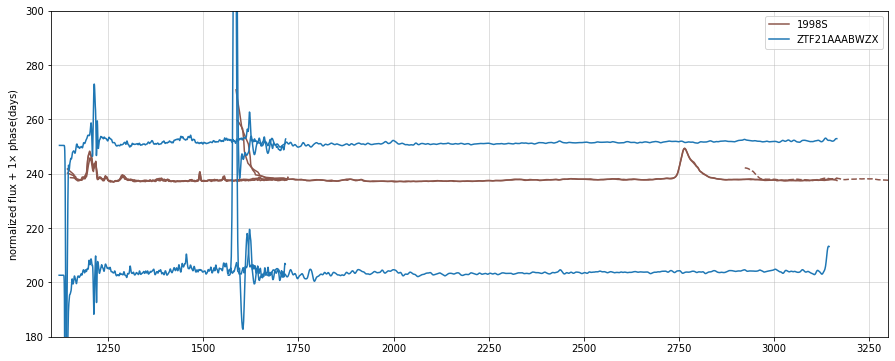

In [11]:
warnings.simplefilter('ignore')

fig = plt.figure(figsize = (15, 6))

plot_spectrum('1998S', sn1998S_list, t0_98S, z_98S, color = 'C5')

#plot_spectrum('2020aekp', sn2020aekp_list, t0_20aekp, z_20aekp, color = 'C10')

x1d = fits.open("./2020aekp/0914FUV_x1d.fits")
phase1 = 250.41908242830135
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase1),
         color = 'C10', label = 'ZTF21AAABWZX')

x1d = fits.open("./2020aekp/0915NUV_x1d.fits")
phase1 = 250.41908242830135
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase1),
         color = 'C10')

x1d = fits.open('./2020aekp/HST/oeczz1010/oeczz1010_x1d.fits')
phase2 = 202.6449106500943
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase2),
         color = 'C10')
x1d = fits.open('./2020aekp/0727NUV_x1d.fits')
phase2 = 202.6449106500943
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase2),
         color = 'C10')

plt.grid(alpha=0.5)


plt.ylabel(r'normalized flux + {:.0f}$\times$ phase(days)'.format(shift(1)))
plt.ylim(180., 300)
plt.xlim(1100, 3300)
plt.legend()

In [27]:
#make a list of all spectra and order them by phase...

import astropy.table as at
all_spec_list = at.Table(names=('object', 'mjd', 'filters', 'obs_col', 'obs_id', 't0','phase', 'redshift'), 
                        dtype = ('S8', 'f8', 'S8', 'S8','S8','f8', 'f8', 'f8'))
for item in sn2015G_list:
    all_spec_list.add_row(['2015G', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_15G, phase(item['t_min'], t0_15G, z_15G), z_15G])

for item in nxt_list:
    all_spec_list.add_row(['2020nxt', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_nxt, phase(item['t_min'], t0_nxt, z_nxt), z_nxt])

#for item in fqv_list:
#    all_spec_list.add_row(['2020fqv', item['t_min'], item['filters'], item['obs_collection'], 
#                           item['obs_id'], t0_fqv, phase(item['t_min'], t0_fqv, z_fqv), z_fqv])
    
for item in sn2010jl_list:
    all_spec_list.add_row(['2010jl', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_10jl, phase(item['t_min'], t0_10jl, z_10jl), z_10jl])
    
for item in sn2005ip_list:
    all_spec_list.add_row(['2005ip', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_05ip, phase(item['t_min'], t0_05ip, z_05ip), z_05ip])
    
for item in sn1998S_list:
    all_spec_list.add_row(['1998S', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_98S, phase(item['t_min'], t0_98S, z_98S), z_98S])
    
#for item in sn2011by_list:
#    all_spec_list.add_row(['2011by', item['t_min'], item['filters'], item['obs_collection'], 
#                           item['obs_id'], t0_11by, phase(item['t_min'], t0_11by, z_11by), z_11by])
    
for item in sn2011fe_list:
    all_spec_list.add_row(['2011fe', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_11fe, phase(item['t_min'], t0_11fe, z_11fe), z_11fe])

#for item in sn2018agk_list:
#    all_spec_list.add_row(['2018agk', item['t_min'], item['filters'], item['obs_collection'], 
#                           item['obs_id'], t0_18agk, phase(item['t_min'], t0_18agk, z_18agk), z_18agk])

for item in sn2021csp_list:
    all_spec_list.add_row(['2021csp', item['t_min'], item['filters'], item['obs_collection'], 
                           item['obs_id'], t0_21csp, phase(item['t_min'], t0_21csp, z_21csp), z_21csp])


In [47]:
all_spec_list.sort('phase')
todel_list = []
for j, item in enumerate(all_spec_list):
    if item['filters'] == 'G750L' or item['filters'] == 'G430L' or item['filters'] == 'G750L' or item['filters'] =='MIRVIS':
        todel_list.append(j)
all_spec_list.remove_rows(todel_list)
all_spec_list

object,mjd,filters,obs_col,obs_id,t0,phase,redshift
bytes8,float64,bytes8,bytes8,bytes44,float64,float64,float64
2011fe,55801.16724236,G230L,HST,obnd48010,55796.696,4.467668225419116,0.0008
2021csp,59263.5067534375,G230L,HST,oedo02010,59255.47,7.420824965370612,0.083
2011fe,55804.29012422,G230L,HST,obnd49010,55796.696,7.588053776977194,0.0008
2021csp,59263.83714876157,G140L,HST,ledo01010,59255.47,7.725899133492175,0.083
2011fe,55807.41668642,G230LB,HST,obnd45010,55796.696,10.712116726616655,0.0008
2021csp,59267.082274155095,G230L,HST,oedo04010,59255.47,10.72232147284716,0.083
2015G,57116.46573993,G230L,HST,ocmy01010,57104.75317,11.660099482323606,0.0045
2015G,57116.52464031,G230L,HST,ocmy01020,57104.75317,11.718735998008095,0.0045
2015G,57116.59090177,G230L,HST,ocmy01030,57104.75317,11.784700617222164,0.0045


In [48]:
#make a list of different filters and identify the useful ones
unique_list = []
     
    # traverse for all elements
for x in all_spec_list['filters']:
        # check if exists in unique_list or not
    if x not in unique_list:
        unique_list.append(x)
    # print list
for x in unique_list:
    print(x)


G230L
G140L
G230LB
G096
E230M
G130M
G160M
G141
G185M
G102


phase 58.44824970023288  2011fe  obnd54060 G230L
phase 58.46725081933986  2011fe  obnd54070 G230L
no spectra found for 1998S n4k6lwuqq
no spectra found for 1998S n4k6lwutq
no spectra found for 1998S n4k6lxuzq
phase 71.40782210369116  1998S  o48z65020 G140L
no spectra found for 1998S n4k6lxv9q
no spectra found for 1998S HNG_J114529.01+473335.5_N4K6LWUQQ_V01.SPEC1D
no spectra found for 1998S HNG_J114529.87+473340.4_N4K6LWUQQ_V01.SPEC1D
no spectra found for 1998S HNG_J114530.75+473316.5_N4K6LWUQQ_V01.SPEC1D
phase 71.46488497507444  1998S  o48z65030 G140L
no spectra found for 1998S n4k6lyvfq
no spectra found for 1998S n4k6lyvlq
phase 71.53188290130123  1998S  o48z65040 G140L
no spectra found for 1998S n4k6lzvrq
no spectra found for 1998S n4k6lzvxq
phase 71.60153505483486  1998S  o48z65050 G230L
no spectra found for 1998S n4k6m0w3q
no spectra found for 1998S n4k6m0wbq
phase 71.66586759720909  1998S  o48z65060 G230L
phase 95.60622023350099  2010jl  obk004010 G230LB
phase 95.62012221232958  2

(1100, 3300)

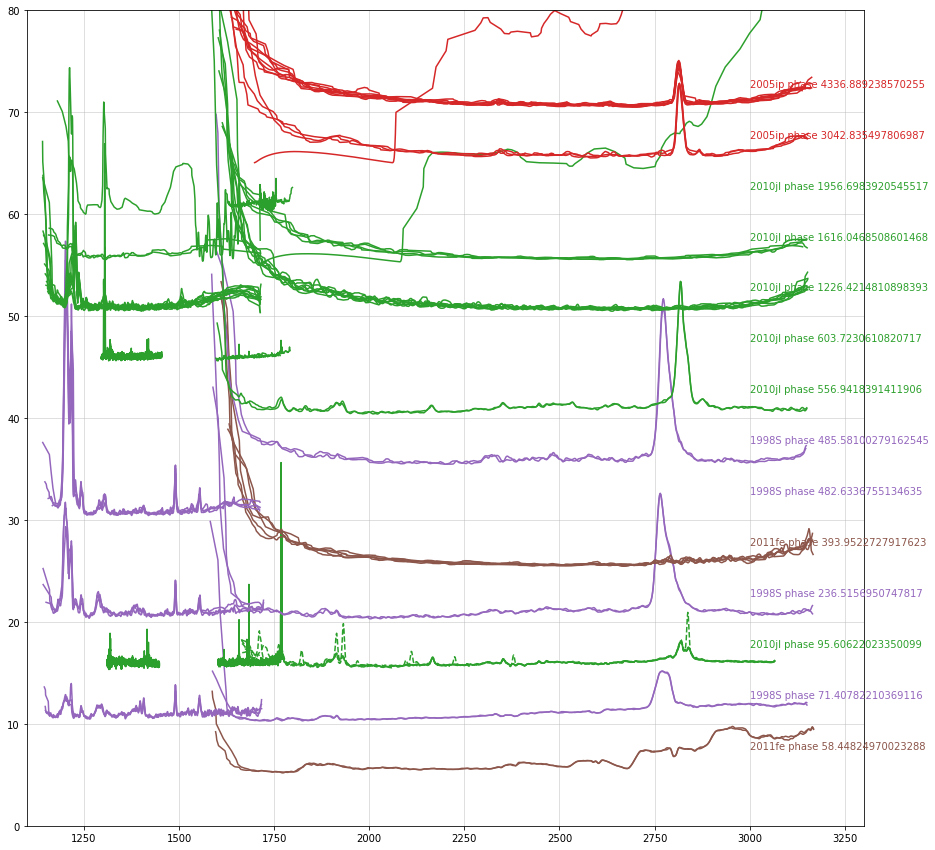

In [105]:
#This block try to find the spectra that has been reduced, i.e. x1d, x1dsum or sx1
#some of them are just redundant files without real spectra
warnings.simplefilter('ignore')

f_upbound = 100.
gussian_sig = 2.
fig = plt.figure(figsize = (15, 15))

color_dict = {'2015G':'C0', '2020nxt':'C1', '2010jl':'C2', '2005ip':'C3', 
              '1998S':'C4', '2011fe':'C5', '2021csp':'C6'}
i = 0
k = 0
start_n = 86
for n,item in enumerate(all_spec_list[start_n:]):
    name = item['object']
    spec_exist = True
    x1d_file = os.path.join('./',name, item['obs_col'], item['obs_id'],  item['obs_id']+'_x1d.fits')
    x1dsum_file = os.path.join('./',name, item['obs_col'], item['obs_id'],  item['obs_id']+'_x1dsum.fits')
    sx1_file = os.path.join('./',name, item['obs_col'], item['obs_id'],  item['obs_id']+'_sx1.fits')
    if os.path.exists(x1d_file):
        if (n ==0) or (name != all_spec_list[n-1-k+start_n]['object']) or (abs(item['phase']-all_spec_list[n-1-k+start_n]['phase'])>1.5):
            i +=5
            plt.text(3000, i+2.5, '{} phase {}'.format(name, item['phase']), color = color_dict[name])
        k = 0
        spectrum = fits.open(x1d_file)
        ind = (spectrum[1].data[0][6]>spectrum[1].data[0][7])&(abs(spectrum[1].data[0][6])<f_upbound*np.median(spectrum[1].data[0][6]))
        plt.plot(spectrum[1].data[0][2][ind], 
                gaussian_filter1d(spectrum[1].data[0][6][ind], gussian_sig)/np.median(spectrum[1].data[0][6][ind])+i, 
                color = color_dict[name])
        print('phase {}  {}  {} {}'.format(item['phase'],name, item['obs_id'], item['filters']))
    elif os.path.exists(x1dsum_file):
        if (n ==0) or (name != all_spec_list[n-1-k+start_n]['object']) or (abs(item['phase']-all_spec_list[n-1-k+start_n]['phase'])>1.5):
            i +=5
            plt.text(3000, i+2.5, '{} phase {}'.format(name, item['phase']), color = color_dict[name])
        k = 0
        spectrum = fits.open(x1dsum_file)
        if len(spectrum[1].data)>0:
            ind = (spectrum[1].data[0][4]>spectrum[1].data[0][5])&(abs(spectrum[1].data[0][4])<f_upbound*np.median(spectrum[1].data[0][4]))      
            plt.plot(spectrum[1].data[0][3][ind], 
                    gaussian_filter1d(spectrum[1].data[0][4][ind], gussian_sig)/np.median(spectrum[1].data[0][4][ind])+i, 
                    color = color_dict[name])
        print('phase {}  {}  {} {}'.format(item['phase'],name, item['obs_id'], item['filters']))
    elif os.path.exists(sx1_file): 
        if (n ==0) or (name != all_spec_list[n-1-k+start_n]['object']) or (abs(item['phase']-all_spec_list[n-1-k+start_n]['phase'])>1.5):
            i +=5
            plt.text(3000, i+2.5, '{} phase {}'.format(name, item['phase']), color = color_dict[name])
        k = 0
        spectrum = fits.open(sx1_file)
        ind = (spectrum[1].data[0][6]>spectrum[1].data[0][7])&(abs(spectrum[1].data[0][6])<f_upbound*np.median(spectrum[1].data[0][6]))
        plt.plot(spectrum[1].data[0][2][ind], 
                gaussian_filter1d(spectrum[1].data[0][6][ind], gussian_sig)/np.median(spectrum[1].data[0][6][ind])+i
                ,  color = color_dict[name], linestyle = '--')
        print('phase {}  {}  {} {}'.format(item['phase'],name, item['obs_id'], item['filters']))
    else:
        print('no spectra found for '+ name+' ' + item['obs_id'])
#        spec_exist = False
        k+=1
        
#    if spec_exist:
#        print(n, k, name, all_spec_list[n-1-k+start_n]['object'], item['phase'], all_spec_list[n-1-k+start_n]['phase'])
#        if (n ==0) or (name != all_spec_list[n-1-k+start_n]['object']) or (abs(item['phase']-all_spec_list[n-1-k+start_n]['phase'])>1.5):
#            plt.text(3000, i+2.5, '{} phase {}'.format(name, item['phase']), color = color_dict[name])
#        else:
#            i +=5
#        k = 0

plt.grid(alpha=0.5)


#plt.ylabel(r'normalized flux + {:.0f}$\times$ phase(days)'.format(shift(1)))
plt.ylim(0., 80)
plt.xlim(1100, 3300)
#plt.legend()

# So here are things to check...
# check 2010jl 95d spectra: difference between x1d and x1dsum
 also check what's wrong with FUV 2010jl 95d spectrum? (less important)
# remove the obvious outliers, two late spectra for 2010jl and 2005ip
 ocdd050f0 and ocdd02090
 what to do with them?
# sum and combine all spectra

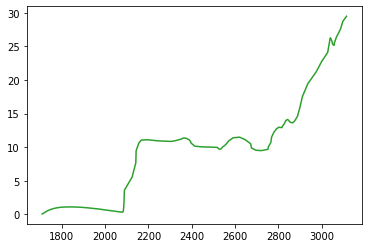

In [100]:
for n,item in enumerate(all_spec_list[-42:-41]):
    name = item['object']
    spec_exist = True
    x1d_file = os.path.join('./',name, item['obs_col'], item['obs_id'],  item['obs_id']+'_x1d.fits')
    if os.path.exists(x1d_file):
        spectrum = fits.open(x1d_file)
        ind = (spectrum[1].data[0][6]>spectrum[1].data[0][7])&(abs(spectrum[1].data[0][6])<f_upbound*np.median(spectrum[1].data[0][6]))
        plt.plot(spectrum[1].data[0][2][ind], 
                    gaussian_filter1d(spectrum[1].data[0][6][ind], gussian_sig)/np.median(spectrum[1].data[0][6][ind])+n, 
                    color = color_dict[name])


In [101]:
all_spec_list[-42:-41]

object,mjd,filters,obs_col,obs_id,t0,phase,redshift
bytes8,float64,bytes8,bytes8,bytes44,float64,float64,float64
2010jl,57121.54767253,G230L,HST,ocdd050f0,55488.0,1616.2537573266086,0.0107


In [ ]:
'./',name, item['obs_collection'], item['obs_id']

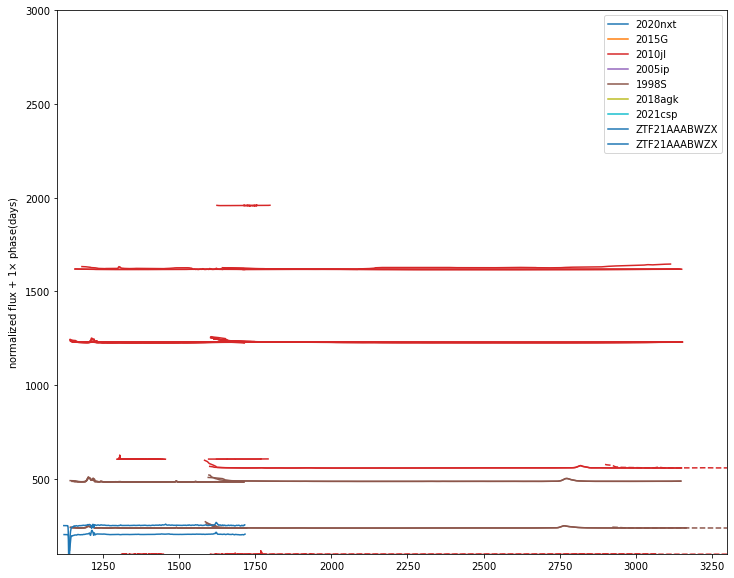

In [19]:
#compare 1998S and 2020aekp

warnings.simplefilter('ignore')

fig = plt.figure(figsize = (12, 10))

plot_spectrum('2020nxt', nxt_list, t0_nxt, z_nxt, color = 'C0')
plot_spectrum('2015G', sn2015G_list, t0_15G, z_15G, gussian_sig = 6, color = 'C1')
#plot_spectrum('2020fqv', fqv_list, t0_fqv, z_fqv, color = 'C2')
plot_spectrum('2010jl', sn2010jl_list, t0_10jl, z_10jl, color = 'C3')
plot_spectrum('2005ip', sn2005ip_list, t0_05ip, z_05ip, color = 'C4')
plot_spectrum('1998S', sn1998S_list, t0_98S, z_98S, color = 'C5')
#plot_spectrum('2011by', sn2011by_list, t0_11by, z_11by, color = 'C6')
#plot_spectrum('2011fe', sn2011fe_list, t0_11fe, z_11fe, color = 'C7')
plot_spectrum('2018agk', sn2018agk_list, t0_18agk, z_18agk, color = 'C8')
plot_spectrum('2021csp', sn2021csp_list, t0_21csp, z_21csp, gussian_sig = 8, color = 'C9')

#plot_spectrum('2020aekp', sn2020aekp_list, t0_20aekp, z_20aekp, color = 'C10')

x1d = fits.open("./2020aekp/0914FUV_x1d.fits")
phase1 = 202.58117578393933
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase1),
         color = 'C10', label = 'ZTF21AAABWZX')

x1d = fits.open('./2020aekp/HST/oeczz1010/oeczz1010_x1d.fits')
phase2 = 250.41908242830135
plt.plot(x1d[1].data['WAVELENGTH'][0],
         gaussian_filter1d(x1d[1].data['FLUX'][0], 2)/np.median(x1d[1].data['FLUX'][0])+shift(phase2),
         color = 'C10', label = 'ZTF21AAABWZX')



plt.ylabel(r'normalized flux + {:.0f}$\times$ phase(days)'.format(shift(1)))
plt.ylim(100., 3000)
plt.xlim(1100, 3300)
plt.legend()

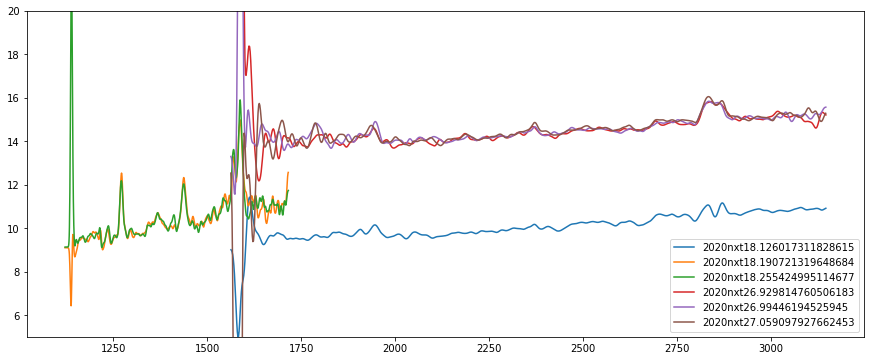

In [385]:
fig = plt.figure(figsize = (15, 6))
name = '2020nxt'
gussian_sig = 4
for item in nxt_list:
    s_phase = phase(item['t_min'], t0_nxt, z_nxt)
    x1d_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_x1d.fits')
    x1dsum_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_x1dsum.fits')
    sx1_file = os.path.join('./',name, item['obs_collection'], item['obs_id'],  item['obs_id']+'_sx1.fits')
    if os.path.exists(x1d_file):
        spectrum = fits.open(x1d_file)
        plt.plot(spectrum[1].data[0][2], 
                 gaussian_filter1d(spectrum[1].data[0][6], gussian_sig)/np.median(spectrum[1].data[0][6])+s_phase/2., 
                 label = name+' d '+str(s_phase))
    elif os.path.exists(sx1_file): 
        spectrum = fits.open(sx1_file)
        plt.plot(spectrum[1].data[0][2], 
                 gaussian_filter1d(spectrum[1].data[0][6], gussian_sig)/np.median(spectrum[1].data[0][6])+s_phase/2.
                 , label = name+' d '+str(s_phase)+item['filters'], linestyle = '--')
    else:
        print('no calibrated spectrum found for ' + row['obs_id'])
plt.ylim(5., 20)
plt.legend()